<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p3/Code_Snippets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will contain code snippets to be used in the tutorials.

# Generation of discrete B-splines through convolution
## The continuous representation
The basis functions of $S_1^n$, called B-splines are defined as
$$\tag{1}
\beta^n(x) = \sum_{j=0}^{n+1}\frac{(-1)^j}{n!}\binom{n+1}{j}\left(x + \frac{n+1}{2} - j\right)^n\mu\left(x + \frac{n+1}{2} - j\right),
$$
where $$\tag{2}
\mu(x) = \begin{cases}
1 & \text{ if } x \ge 0 \\
0 & \text{ otherwise}
\end{cases}
$$ is the step function. It can be shown that [2]
$$\tag{3}
\beta^n(x) = (\beta^{n-1} \star \beta^0)(x).
$$

We show how to implement equation (3) in the cell below. We start with $\beta^0$
defined using equation (1) as
$$\tag{4}
\beta^0(x) = \mu\left(x + \frac{1}{2}\right) - \mu\left(x - \frac{1}{2}\right)
$$


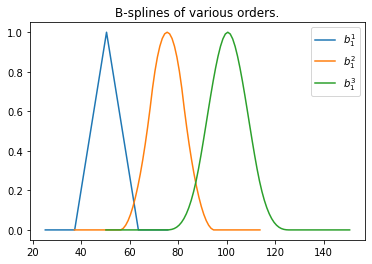

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# The unit step function.
def mu(x):
    y = np.ones(len(x))
    # Select indices of x such that x[i] < 0.
    si = np.where(x < 0)[0]
    y[si] = 0

    return y

lo = -2
hi = 2
n_samples = 51

x = np.linspace(lo, hi, n_samples)

# We construct the lowest order function in terms of unit steps. The higher
# order functions will be generated using convolutions of the lower order ones.
def beta_0(x):
    b0 = mu(x + 1/2)
    b1 = mu(x - 1/2)

    return b0 - b1

# Convolution and normalization.
# We have to normalize because we do not have an analog of the factor 1/m^n
# multiplying the convolutions as in the case of m > 1. Even if that factor were
# present, it would have been ineffective.
def convolve_and_normalize(x, y):
    z = np.convolve(x, y)
    z = z/np.max(z)

    return z

# Add a spline to a plot.
def add_to_plot(y, m, n):
    l = len(y)
    x = np.linspace(0, l, l)

    # We try to ignore the portion with zeros as much as possible.
    left = l//4
    right = l - left
    #left = 0
    #right = l

    plt.plot(x[left:right], y[left:right], label = rf'$b_{m}^{n}$'.format(m, n))


beta_0_1 = beta_0(x)
beta_1_1 = convolve_and_normalize(beta_0_1, beta_0_1)
beta_2_1 = convolve_and_normalize(beta_1_1, beta_0_1)
beta_3_1 = convolve_and_normalize(beta_2_1, beta_0_1)

add_to_plot(beta_1_1, 1, 1)
add_to_plot(beta_2_1, 1, 2)
add_to_plot(beta_3_1, 1, 3)
plt.legend()
plt.title('B-splines of various orders.')
plt.show()


## The discrete representation
In order to compute discrete splines we use the equations (3.1), (3.2), (3.3) and (3.4) from reference [2]. Use them to compute table I of the same paper.

In [0]:
def b(n, m, k):
  if n == 0:
    if -m/2 <= k and k <= m/2:
      rv = 1 # rv stands for return value.
    else:
      rv = 0
  else:
    rv = ((k/m + (n + 1)/2) * c(n-1, m, k) + ((n + 1)/2 - k/m) * c(n - 1, m, k - m))/n

  return rv

def c(n, m, k):
  if n == 0:
    if 1 - m <= k and k <= 0:
      rv = 1  # rv stands for return value.
    else:
      rv = 0
  else:
    rv = ((k/m + (n + 2)/2) * b(n - 1, m, k + m) + (n/2 - k/m) * b(n - 1, m, k))/n

  return rv

In order to find out the discrete spline $b_1^2$ we need the values of $b(2, 1, k)$ for $k = -2, -1, 0, 1, 2$. We do that in the code snippet below and confirm that they are $[1/8, 6/8, 1/8]$ or, in decimals, $[0.125, 0.75, 0.125]$.

In [0]:
# We follow the convention b_n_m[k] = b(n, m, k).
b_2_1 = np.zeros(5)
for k in range(-2, 3):
  # We want the signal index to be -2, -1, 0, 1, 2.
  # We simulate it on python's index by adding 2.
  b_2_1[k + 2] = b(2, 1, k)

print(b_2_1)

[0.    0.125 0.75  0.125 0.   ]


Similarly, the values of $b_1^3$ are confirmed to be $[1/6, 2/3, 1/6] = [0.167,0.667, 0.167]$, where we have rounded the decimals to three places.

In [0]:
# Recall the convention b_n_m[k] = b(n, m, k).
b_3_1 = np.zeros(7)
for k in range(-3, 4):
  # We want the signal index to be -3. -2, -1, 0, 1, 2, 3.
  # We simulate it on python's index by adding 3.
  b_3_1[k + 3] = b(3, 1, k)

print(np.round(b_3_1, 3))

[0.    0.    0.167 0.667 0.167 0.    0.   ]


There are two ways to compute these coefficients. One can either use the functions we defined above or one can read off the coefficients of the $z$-transform $B_1^n(z)$. A recursive formula for finding $z$-transform is given by equation (2.7) of reference [1]. We mention it here,
$$
B_m^n(z) = \frac{1}{m^n}B_1^n(z)\left(B_m^0(z)\right)^{n+1},
$$
where $B_m^0(z)$ is given by equation (2.9) of the same reference
$$
B_m^0(z) = \sum_{k=0}^{m-1}z^{-k}.
$$


# Frequency response of $H_\lambda^n$

The transfer function is given by
$$\tag{1}
H_\lambda^n(z) = \frac{B_1^n(z)}{B_1^n(z) + \lambda(-z + 2 -z^{-1})^{(n+1)/2}}
$$
If $n = 3$, 
$$\tag{2}
B_1^3(z) = \frac{z + 4 + z^{-1}}{6}
$$
so that
$$\tag{3}
H_\lambda^3(z) = \frac{z + 4 + z^{-1}}{z + 4 + z^{-1} + 6\lambda(-z + 2 + z^{-1})^2}.
$$
It can be simplified to
$$\tag{4}
H_\lambda^3(z) =\frac{z + 4z^2 + z^3}{6\lambda + (1-24\lambda)z + 4(1 + 9\lambda)z^2 + (1 - 24\lambda)z^3 + 6\lambda z^5}.
$$


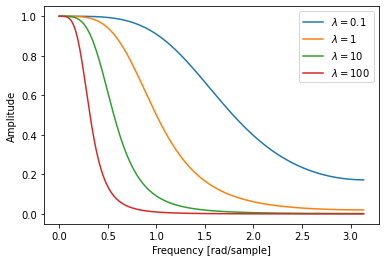

Freqency response of a cubic spline filter.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def compute_a(_lambda):
  return [6*_lambda, 1 - 24*_lambda, 4*(1 + 9*_lambda), 1 - 24*_lambda, 6*_lambda]

b = [0, 1, 4, 1]

def get_freq_response(_lambda):
  a = compute_a(_lambda)
  w, h = signal.freqz(b, a)
  plt.plot(w, abs(h), label = rf'$\lambda = {_lambda}$')

all_lambdas = [0.1, 1, 10, 100]
for _lambda in all_lambdas:
  get_freq_response(_lambda)

plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()
print('Freqency response of a cubic spline filter.')

No handles with labels found to put in legend.


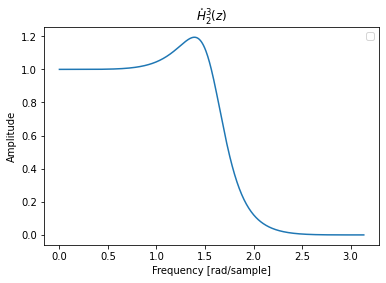

Frequency response of an optimal pre-filter.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

b = [0, 8, 64, 216, 512, 928,1152, 928, 512, 216, 64, 8]
a = [1, 0, 110, 0, 1087, 0, 2216, 0, 1087, 0, 110, 0, 1]

w, h = signal.freqz(b, a)
plt.plot(w, abs(h))

plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude')
plt.legend()
plt.title(r'$\mathring{H}_2^3(z)$')
plt.show()
print('Frequency response of an optimal pre-filter.')

# Cardinal spline and its Fourier transform

The cubic cardinal spline is defined as (see equation (3.20) of reference[1]),
$$\tag{1}
\eta^3(x) = \frac{-6\alpha}{1 - \alpha^2}\sum_{k=-\infty}^\infty \alpha^{|k|}\beta^3(x - k),
$$
where $\alpha = \sqrt{3} - 2$ and $\beta^3$ is a cubic B-spline. The frequency response of the spline shows that it is non-zero only for a small band of frequencies in the nrighborhood of zero. A cubic cardinal spline is thus an ideal low-pass filter.

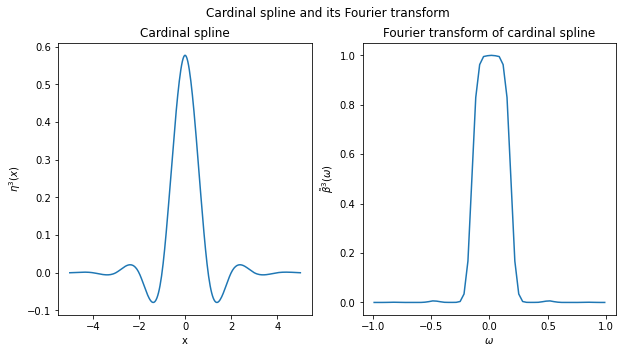

In [13]:
# Cardinal spline and its Fourier transform

import math
import numpy as np
import matplotlib.pyplot as plt

def mu(x):
    y = np.ones(len(x))
    si = np.where(x < 0)[0]
    y[si] = 0

    return y

def beta3(x):
    b_0 = np.multiply(pow(x + 2, 3), mu(x + 2))/6
    b_1 = -2/3 * np.multiply(pow(x + 1, 3), mu(x + 1))
    b_2 = np.multiply(pow(x, 3), mu(x))
    b_3 = -2/3 * np.multiply(pow(x - 1, 3), mu(x - 1))
    b_4 = np.multiply(pow(x - 2, 3), mu(x - 2))/6

    return b_0 + b_1 + b_2 + b_3 + b_4

alpha = math.sqrt(3) - 2

def eta(x):
    sum = 0
    for k in range(-5, 6):
        sum = sum + math.pow(alpha, abs(k)) * beta3(x - k)

    return sum

x = np.linspace(-5, 5, 300)
y = eta(x)

cf = np.abs(np.fft.fft(y))
# Normalize it.
cf1 = np.fft.fftshift(cf)/np.max(cf)

fig = plt.figure(figsize = (10, 5))
fig.suptitle('Cardinal spline and its Fourier transform')
p1 = plt.subplot(121)
p1.set_title('Cardinal spline')
plt.plot(x, y, label = r'$\eta^3(x)$')
plt.xlabel('x')
plt.ylabel(r'$\eta^3(x)$')

left = 120
right = 180
p2 = plt.subplot(122)
p2.set_title('Fourier transform of cardinal spline')
plt.plot(x[left:right], cf1[left:right], label = r'$\tilde{\eta}^3$')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\tilde{\beta}^3(\omega)$')
plt.show()


# Some image processing algorithms

## Vertical gradient
The filter is
$$\tag{1}
\nabla_v = \frac{1}{12}\begin{pmatrix}1 \\ 0 \\ -1\end{pmatrix}\otimes\begin{pmatrix}1 & 4 & 1\end{pmatrix} = \frac{1}{12} \begin{pmatrix}1 & 4 & 1 \\ 0 & 0 & 0 \\ -1 & 4 & -1\end{pmatrix}.
$$

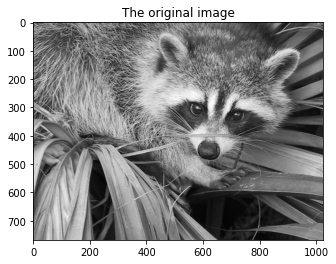

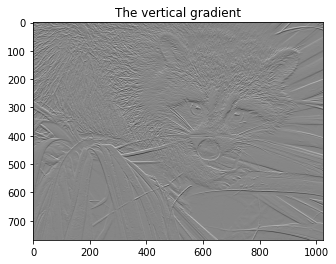

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
grad_v = np.array([[1, 4, 1], [0, 0, 0], [-1, -4, -1]])/12
f1 = signal.convolve2d(img, grad_v, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The vertical gradient')

## Horizontal gradient
The filter is
$$\tag{1}
\nabla_h = \frac{1}{12}\begin{pmatrix}1 \\ 4 \\ 1\end{pmatrix}\otimes\begin{pmatrix}1 & 0 & -1\end{pmatrix} = \frac{1}{12} \begin{pmatrix}1 & 0 & -1 \\ 4 & 0 & -4 \\ 1 & 0 & -1\end{pmatrix}.
$$

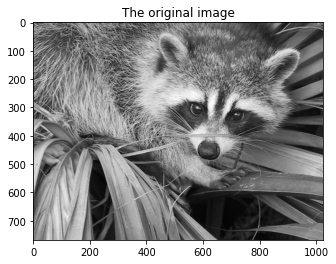

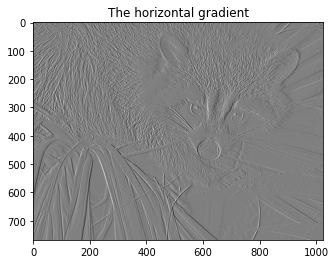

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
grad_h = np.array([[1, 0, -1], [4, 0, -4], [1, 0, -1]])/12
f1 = signal.convolve2d(img, grad_h, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The horizontal gradient')

## Laplacian

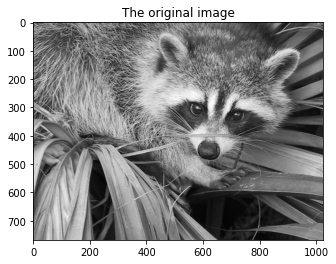

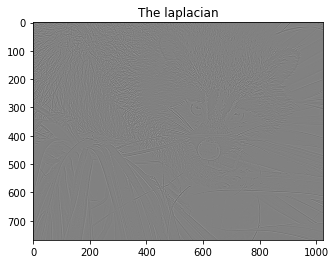

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
f1 = signal.convolve2d(img, laplacian, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The laplacian')

## Cubic spline filter
The filter is
$$\tag{1}
\frac{1}{6}\begin{pmatrix}1 \\ 4 \\ 1\end{pmatrix}\otimes\frac{1}{6}\begin{pmatrix} 1 & 4 & 1 \end{pmatrix} = \frac{1}{36}\begin{pmatrix}1 & 4 & 1 \\ 4 & 16 & 4 \\ 1 & 4 & 1\end{pmatrix}
$$

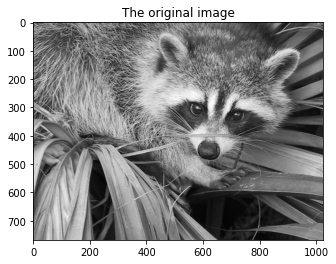

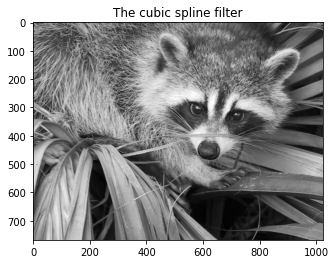

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The cubic spline filter')

## Cubic spline followed by derivatives

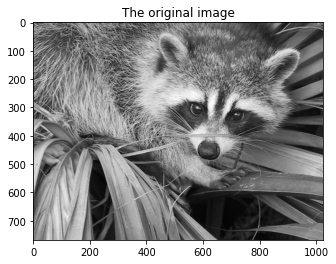

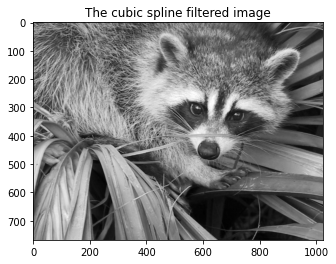

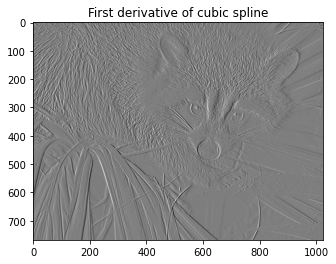

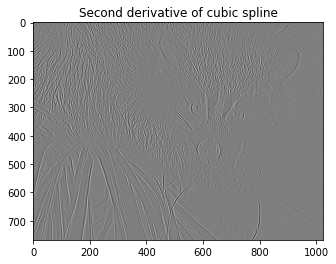

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)
grad_h = np.array([[1, 0, -1], [4, 0, -4], [1, 0, -1]])/12

# Cubic spline filtered
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
df1 = signal.convolve2d(f1, grad_h, mode = 'same', boundary = 'symm')
df2 = signal.convolve2d(df1, grad_h, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The cubic spline filtered image')
display_image(df1, 'First derivative of cubic spline')
display_image(df2, 'Second derivative of cubic spline')

## Decimation

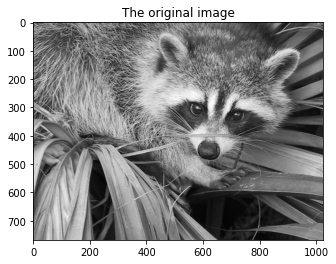

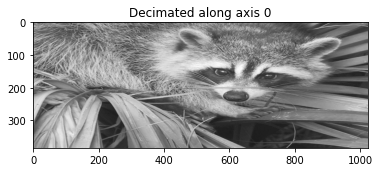

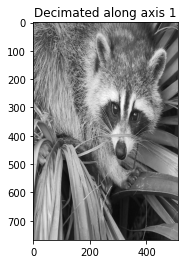

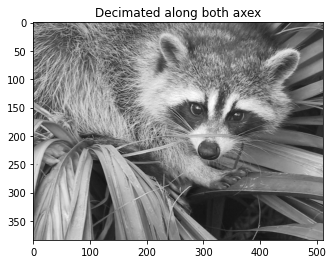

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

img = misc.face(gray=True).astype(np.float32)
fx = signal.decimate(img, 2, axis = 0)
fy = signal.decimate(img, 2, axis = 1)
fxy = signal.decimate(fx, 2, axis = 1)

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(fx, 'Decimated along axis 0')
display_image(fy, 'Decimated along axis 1')
display_image(fxy, 'Decimated along both axes')
print('Read the axes of the first and fourth images carefully.')
print('The second image is indeed decimated by a factor of 2.')

# Smoothing of images

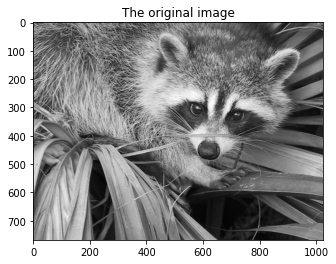

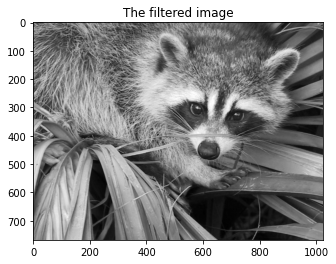

In [22]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

lmbd = 10
xi = 1 - 96*lmbd + 24 * lmbd * math.sqrt(3 + 144*lmbd)

# Calculate rho
rho1 = (24*lmbd - 1 - math.sqrt(xi))/(24 * lmbd)
rho2 = (48*lmbd + 24*lmbd*math.sqrt(3 + 144*lmbd))/xi
rho = rho1 * math.sqrt(rho2)

# Calculate omega
omega = math.atan(math.sqrt((144 * lmbd - 1)/xi))

gamma = ((1 - rho**2)/(1 + rho**2)) * math.sqrt(xi/(144 * lmbd - 1))
c0 = ((1 + rho**2)/(1 - rho**2)) * ((1 - 2 * rho * math.cos(omega) + rho**2)/(1 + 2 * rho * math.cos(omega) + rho**2))

# Compute the 1-d filter
s = [c0 * rho * (math.cos(omega) + gamma * math.sin(omega)),
     c0 * 1.0 * 1,
     c0 * rho * (math.cos(omega) + gamma * math.sin(omega))]

# Compute the 2-d filter
s2 = np.outer(s, s)

img = misc.face(gray=True).astype(np.float32)
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

display_image(img, 'The original image')
display_image(f1, 'The filtered image')

# Cubic spline pyramid


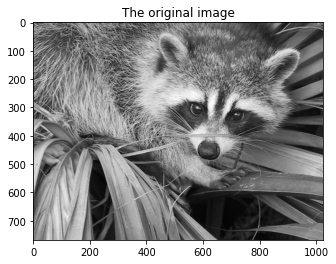

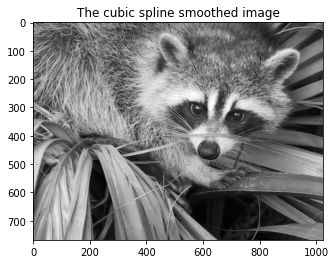

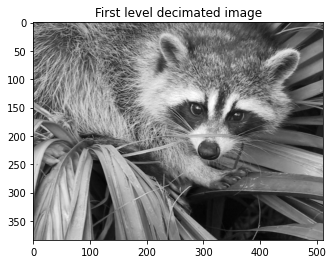

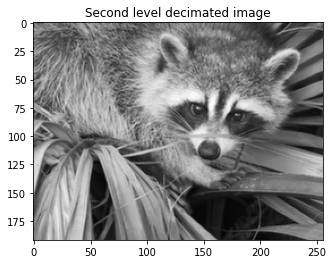

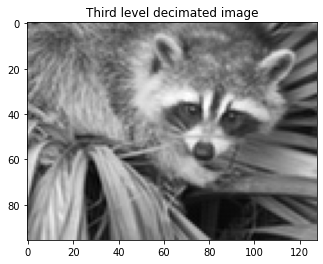

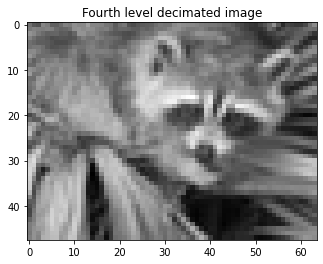

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

# Build the cubic B-spline filter
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

img = misc.face(gray=True).astype(np.float32)
display_image(img, 'The original image')
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
display_image(f1, 'The cubic spline smoothed image')

# First level of decimation
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'First level decimated image')

# Second level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'Second level decimated image')

# Third level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'Third level decimated image')

# Fourth level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
display_image(fxy, 'Fourth level decimated image')


# Cubic spline pyramid with laplacian at each level

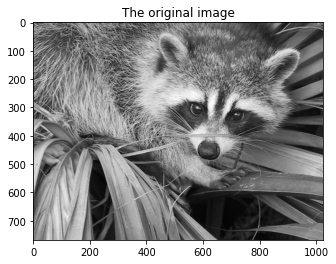

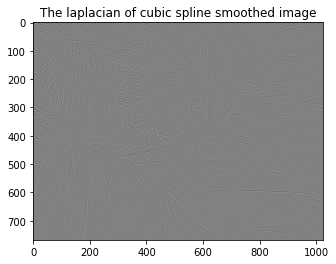

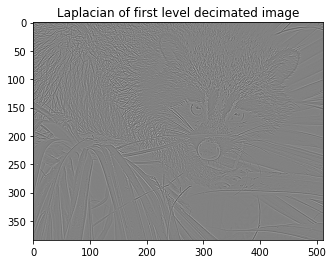

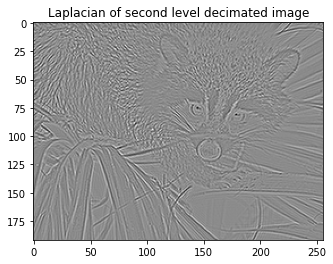

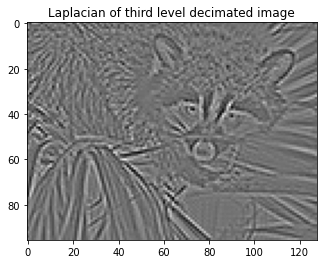

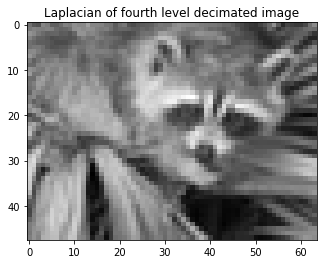

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, misc

# Build the cubic B-spline filter
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)

# Build the laplacian filter
# laplacian = np.outer([1, -2, 1], [1, -2, 1])
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

def display_image(image, title_str):
  plt.figure()
  plt.imshow(image)
  plt.gray()
  plt.title(title_str)
  plt.show()

img = misc.face(gray=True).astype(np.float32)
display_image(img, 'The original image')
f1 = signal.convolve2d(img, csf, mode = 'same', boundary = 'symm')
df1 = signal.convolve2d(img, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'The laplacian of cubic spline smoothed image')

# First level of decimation
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian of first level decimated image')

# Second level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian of second level decimated image')

# Third level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(df1, 'Laplacian of third level decimated image')

# Fourth level of decimation
f1 = signal.convolve2d(fxy, csf, mode = 'same', boundary = 'symm')
fxy = signal.decimate(signal.decimate(f1, 2, axis = 0), 2, axis = 1)
df1 = signal.convolve2d(fxy, laplacian, mode = 'same', boundary = 'symm')
display_image(fxy, 'Laplacian of fourth level decimated image')


References:

[1] Unser, Michael, Akram Aldroubi, and Murray Eden. "Fast B-spline transforms for continuous image representation and interpolation." IEEE Transactions on Pattern Analysis & Machine Intelligence 3 (1991): 277-285.

[2] Unser, Michael, Akram Aldroubi, and Murray Eden. "B-spline signal processing. I. Theory." IEEE transactions on signal processing 41.2 (1993): 821-833.

[3] Unser, Michael, Akram Aldroubi, and Murray Eden. "B-spline signal processing. II. Efficiency design and applications." IEEE transactions on signal processing 41.2 (1993): 834-848.
